# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import time
from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score, make_scorer)

import matplotlib.pyplot as plt
import seaborn as sns

# Util funcs

Podaci su prečišćeni korišćenjem funkcije `handle_invalid_action_images(dataset)` dostupnoj i korišćenoj u svesci `../02_dataset_creation/07_handle_invalid_action_images.ipynb`, tako da u nastavku nisu neophodne dodatne provere u vezi formata slika, i sl.

In [2]:
def load_data(path, y):
    X = []
    path = os.path.join(path, y)
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                X.append(np.array(img))
    
    return X, [y] * len(X)

In [3]:
def print_time_taken(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Time taken: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

# Korišćenje konačnog, prečišćenog skupa

Ove 2 sveske su odvojene da bi se lakše analizirali dobijeni rezultati i da se ne zatrpavaju sveske.

## Učitavanje i preprocesiranje podataka

In [4]:
images = []
labels = []
for i, label in enumerate(os.listdir('/app/tennis_data/stroke_recognition_dataset/master/v1.0/action_images_dataset_v1.0/bottom')):
    X, y = load_data('/app/tennis_data/stroke_recognition_dataset/master/v1.0/action_images_dataset_v1.0/bottom', label)
    images += X
    labels += y
images = np.array(images)

In [5]:
X = images.reshape((len(images), -1))
y = labels

In [6]:
class_labels = ['backhand', 'forehand', 'other', 'serve']

In [7]:
bh_cnt = sum([1 for l in y if l == 'backhand'])
fh_cnt = sum([1 for l in y if l == 'forehand'])
other_cnt = sum([1 for l in y if l == 'other'])
serve_cnt = sum([1 for l in y if l == 'serve'])
print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
print(f'All strokes count: {len(y)}')

Backhands count: 1895, Forehands count: 2293, Other count: 6142, Serve count: 1587
All strokes count: 11917


## Isprobavanje logističke regresije

**Napomena da je u celom projektu korišćeno determinističko razdvajanje na trening, validacioni i test skup (random_state=42), tako da je analiza test skupa pokrenuta tek na kraju celog projekta u svakoj svesci za svaki model.**

`saga` rešavač najčešće izbacuje upozorenje da je moguće nastaviti treniranje, međutim isprobane su razne opcije i nisu postignuti bolji rezultati na validacionom skupu `ConvergenceWarning: The max_iter was reached which means the coef_ did not converge "the coef_ did not converge", ConvergenceWarning)`, tako da je ostavljeno svuda `max_iter=100` da se ne gubi vreme nepotrebno.

In [8]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, 
                                                                          test_size=0.1, 
                                                                          stratify=y, 
                                                                          random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

clf = LogisticRegression(penalty='l1', solver='saga', C=0.1, random_state=7, max_iter=100, n_jobs=50)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, n_jobs=50, penalty='l1', random_state=7,
                   solver='saga')

In [9]:
y_val_preds = clf.predict(X_val)
y_train_preds = clf.predict(X_train)

In [10]:
print("\nTraining set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))


Training set scores:
Accuracy: 0.8965034965034965
Precision: 0.8793572987674861
Recall: 0.873202262425817
F1 Score: 0.8759456523193152

Validation set scores:
Accuracy: 0.875058275058275
Precision: 0.8533432186778267
Recall: 0.844289200577272
F1 Score: 0.8481594269729426


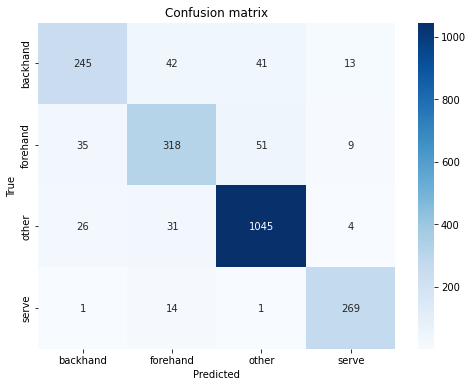

In [11]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.83      0.77      0.80      1364
    forehand       0.82      0.80      0.81      1651
       other       0.93      0.95      0.94      4422
       serve       0.94      0.96      0.95      1143

    accuracy                           0.90      8580
   macro avg       0.88      0.87      0.88      8580
weighted avg       0.90      0.90      0.90      8580



In [13]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.80      0.72      0.76       341
    forehand       0.79      0.77      0.78       413
       other       0.92      0.94      0.93      1106
       serve       0.91      0.94      0.93       285

    accuracy                           0.88      2145
   macro avg       0.85      0.84      0.85      2145
weighted avg       0.87      0.88      0.87      2145



Odmah možemo da primetimo dosta bolje ponašanje na čistijem skupu podataka, što je i bilo očekivano.

## Pronalaženje najboljih hiperparametara

In [14]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y,
                                                                          test_size=0.2, 
                                                                          stratify=y, 
                                                                          random_state=42)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

In [16]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

params = [
    {
        'logreg__penalty': ['l1', 'l2'],
        'logreg__C': [10**i for i in range(-5, 5)],
        'logreg__solver': ['saga'],
    },
    {
        'logreg__penalty': ['elasticnet'],
        'logreg__C': [10**i for i in range(-5, 5)],
        'logreg__solver': ['saga'],
        'logreg__l1_ratio': [0.0, 0.05, 0.1, 0.2]  # only used for elasticnet
    }
]

grid_model = Pipeline(steps=[('scaler', StandardScaler()),
                             ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

Prvo se vrši pretraga prostora za parametre bez opcije `elastic_net`, a onda koristeći `elastic_net` i samo u tom slučaju smisleni `l1_ratio`.

### Analiza hiperparametara bez `elastic_net`-a

In [17]:
start = time.time()

grid_params_0 = GridSearchCV(grid_model, param_grid=params[0], scoring='f1_macro', verbose=True,
                             cv=kf, return_train_score=True, n_jobs=30)
grid_params_0.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Time taken: 00:12:14.64


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [18]:
best_model = grid_params_0.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_0.best_score_}")
print(f"Best parameters: {grid_params_0.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.8843876022602516
Best parameters: {'logreg__C': 1000, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}

Training set scores:
Accuracy: 0.9352216102806189
Precision: 0.9241427363847067
Recall: 0.9210148994875369
F1 Score: 0.9225037277771675

Validation set scores:
Accuracy: 0.940744625065548
Precision: 0.930341160935152
Recall: 0.9340554687509437
F1 Score: 0.9321723014175851


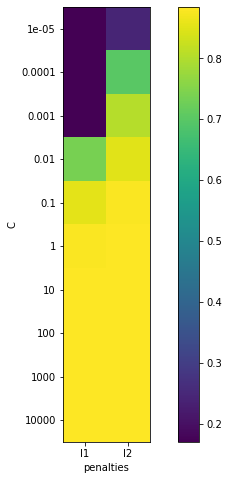

In [19]:
Cs = params[0]['logreg__C']
penalties = params[0]['logreg__penalty']

cv_results = pd.DataFrame(grid_params_0.cv_results_)
cv_test_score = cv_results['mean_test_score'].values.reshape(len(Cs), len(penalties))

plt.figure(figsize=(10, 8))

plt.ylabel('C')
plt.yticks(np.arange(0, len(Cs)), Cs)

plt.xlabel('penalties')
plt.xticks(np.arange(0, len(penalties)), penalties)

plt.imshow(cv_test_score, cmap='viridis')
plt.colorbar()
plt.show()

Praktično je ista situacija kao kod neprečišćenog skupa podataka, pa je ostavljen isti komentar.

Neće biti navođeno sve da se ne zatrpava sveska. Na kraju su odabrani najbolji parametri iz prvog pokretanja `{'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}`. Videćemo koji rezultat daje sledeći skup parametara gde će se koristiti elastic_net, pa ćemo odabrati konačan skup parametara za treniranje modela nad početnim trening i validacionim skupom. Na kraju, ocenićemo model na test skupu.

### Analiza hiperparametara sa `elastic_net`-om

In [20]:
start = time.time()

grid_params_1 = GridSearchCV(grid_model, param_grid=params[1], scoring='f1_macro', verbose=True,
                             cv=kf, return_train_score=True, n_jobs=50)
grid_params_1.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Time taken: 00:15:26.68


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [21]:
best_model = grid_params_1.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_1.best_score_}")
print(f"Best parameters: {grid_params_1.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.8843876022602516
Best parameters: {'logreg__C': 1000, 'logreg__l1_ratio': 0.0, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga'}

Training set scores:
Accuracy: 0.9352216102806189
Precision: 0.9241427363847067
Recall: 0.9210148994875369
F1 Score: 0.9225037277771675

Validation set scores:
Accuracy: 0.940744625065548
Precision: 0.930341160935152
Recall: 0.9340554687509437
F1 Score: 0.9321723014175851


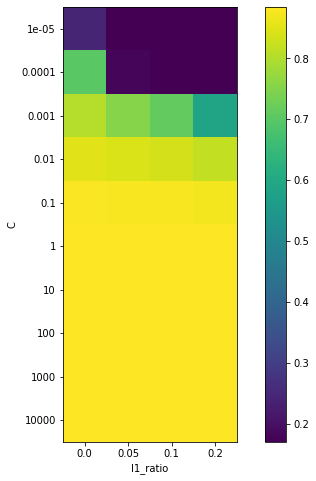

In [22]:
Cs = params[1]['logreg__C']
l1_ratios = params[1]['logreg__l1_ratio']

cv_results = pd.DataFrame(grid_params_1.cv_results_)
cv_test_score = cv_results['mean_test_score'].values.reshape(len(Cs), len(l1_ratios))

plt.figure(figsize=(10, 8))

plt.ylabel('C')
plt.yticks(np.arange(0, len(Cs)), Cs)

plt.xlabel('l1_ratio')
plt.xticks(np.arange(0, len(l1_ratios)), l1_ratios)

plt.imshow(cv_test_score, cmap='viridis')
plt.colorbar()
plt.show()

Ovo je ujedno i konačni model i kvalitet modela, koji je dobijen ugnježdenom unakrsnom validacijom. Neće biti treniran model nad svim podacima iz skupa (uključujući i test), nego će biti eksportovana verzija trenirana nad trening i validacionim skupom da bi se prilikom demonstracije ili bilo kog daljeg koraka mogli koristiti primeri iz test skupa i dobijala relevantna predviđanja.

Napomenućemo samo da je ovde vrednost max_iter povećana na 1000, jer je sa 100 iteracija model dosta bolje rezultate za validacioni skup, tako da je bilo još prostora za trening. Čak i sa 1000, deluje da ima još potencijala (u nadi da neće overfitovati). Tako da stajemo ovde i koristimo ovaj najbolji model.

In [23]:
y_val_preds = best_model.predict(X_val)
y_train_preds = best_model.predict(X_train)

In [24]:
print("\nTraining set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))


Training set scores:
Accuracy: 0.9352216102806189
Precision: 0.9241427363847067
Recall: 0.9210148994875369
F1 Score: 0.9225037277771675

Validation set scores:
Accuracy: 0.940744625065548
Precision: 0.930341160935152
Recall: 0.9340554687509437
F1 Score: 0.9321723014175851


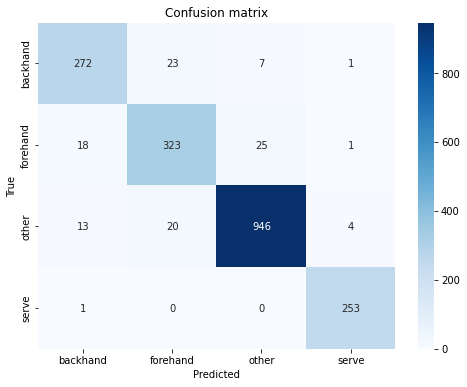

In [25]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.88      0.85      0.86      1213
    forehand       0.88      0.88      0.88      1467
       other       0.96      0.97      0.97      3930
       serve       0.98      0.99      0.98      1016

    accuracy                           0.94      7626
   macro avg       0.92      0.92      0.92      7626
weighted avg       0.93      0.94      0.93      7626



In [27]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.89      0.90      0.90       303
    forehand       0.88      0.88      0.88       367
       other       0.97      0.96      0.96       983
       serve       0.98      1.00      0.99       254

    accuracy                           0.94      1907
   macro avg       0.93      0.93      0.93      1907
weighted avg       0.94      0.94      0.94      1907



Možemo videti da se ovaj model dosta bolje ponaša, najviše zahvaljujući boljim podacima.

## Procena modela na test skupu

In [32]:
y_test_preds = best_model.predict(X_test)

print("\nTest set scores:")
print("Accuracy:", accuracy_score(y_test, y_test_preds))
print("Precision:", precision_score(y_test, y_test_preds, average='macro'))
print("Recall:", recall_score(y_test, y_test_preds, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_preds, average='macro'))


Test set scores:
Accuracy: 0.9043624161073825
Precision: 0.8897554754345818
Recall: 0.8831610140775759
F1 Score: 0.8863139226934603


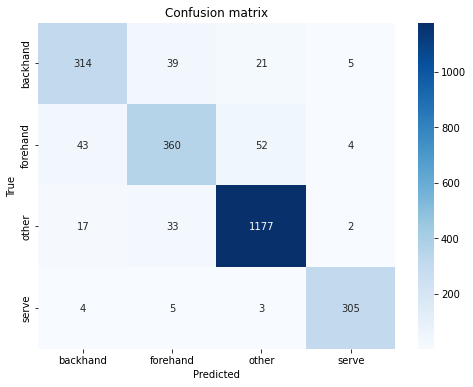

In [33]:
cm = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [34]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

    backhand       0.83      0.83      0.83       379
    forehand       0.82      0.78      0.80       459
       other       0.94      0.96      0.95      1229
       serve       0.97      0.96      0.96       317

    accuracy                           0.90      2384
   macro avg       0.89      0.88      0.89      2384
weighted avg       0.90      0.90      0.90      2384



Na kraju možemo da primetimo da smo dosta popravili onaj inicijalni model, koji je kreiran nasumičnim probanjem parametara, odnosno pronalaženje hiperparametara je donelo rezultat. Ipak, vidimo da, očekivano, model ne daje tako dobre rezultate za test skup, validacioni skup. Malo smo se preprilagodili podacima, verovatno između ostalog baš korišćenjem velikog broja iteracija. Ovo je konačan kvalitet razvijenog modela. Ovaj model je zahvaljujući dobro labeliranom skupu podataka značajno bolji od prethodnog modela dobijenog primenom logističke regresije.

# Čuvanje modela, odnosno celog pipeline-a za kasniju upotrebu

In [35]:
import pickle

if not os.path.exists('../../models'):
    os.makedirs('../../models')
        
with open('../../models/01_logistic_regression_clean_data.pkl', 'wb') as f:
    pickle.dump(best_model, f)